In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 
import bottleneck as bn

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 3) array of binary states into (N, M) indices in [0..7].

    Mapping:
      - [a, b, c] are binary bits (0 or 1), forming a 3-bit number: a*4 + b*2 + c
      - NaN-safe: if any of the 3 elements is NaN, output is NaN

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 3).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M) with values in [0..7] or NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 3).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    valid_data = all_state_array[valid_mask]  # shape (?, 3)

    a = valid_data[:, 0]
    b = valid_data[:, 1]
    c = valid_data[:, 2]

    result = (a * 4 + b * 2 + c).astype(float)
    indexed_states[valid_mask] = result

    return indexed_states


In [5]:
def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state

In [6]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Make a whole np traj.shape (742, 196095, 3) with nan, and convert the [111] into individual 8 state, then index it to (742, 196095)

In [7]:
omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array

In [8]:
print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

742


array([[   0.83861196,  -14.872943  ,    7.2696185 ],
       [ -15.203701  ,   20.326454  ,  -13.589486  ],
       [ -22.909151  ,   31.408817  ,    5.943763  ],
       ...,
       [-165.82278   , -165.66798   ,   -7.168535  ],
       [-154.66087   , -151.77087   ,   19.364212  ],
       [-145.88448   , -140.96645   ,   12.772504  ]], dtype=float32)

In [9]:
## Create a (ntraj, ntimestep) with 3 binary cistrans convert to conform state [0...7]

ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

print('traj.shape', traj.shape)


all_traj_indexed = state_to_index_vectorized(traj)

all_traj_indexed = np.array(all_traj_indexed)
print('all_traj_indexed.shape', all_traj_indexed.shape)
all_traj_indexed[1]


maxlength 345495
traj.shape (742, 345495, 3)
all_traj_indexed.shape (742, 345495)


array([ 0.,  0.,  0., ..., nan, nan, nan])

(345495,)


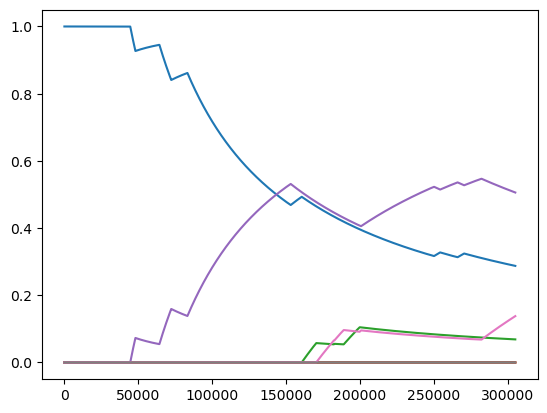

In [10]:
conform_num = 8

conform_population = calculate_conform_p(all_traj_indexed[1], conform_num)
print(all_traj_indexed[0].shape)
plt.plot(conform_population.T)  # Transpose: shape (37002, 32)
#plt.ylim(0, 0.125)

In [11]:
## Load the error from MSM

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conform.csv")
#print(df_stationary_p)


# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
refer_array = pivot_mean.to_numpy()  # shape (1, 8) state, residues 
refer_err_array = pivot_std.to_numpy()  # shape (1, 8)
refer_array.shape

(1, 8)

In [12]:
refer_array.squeeze().shape

(8,)

## Calculate the MEAN, RMSD

In [22]:
conform_num = 8
n_traj = all_traj_indexed.shape[0]

# Store population results from each trajectory
all_conform_populations = []

for i in tqdm(range(n_traj), desc="Processing all trajectories"):
    single_traj = all_traj_indexed[i]
    # Skip NaNs inside calculate_conform_p
    conform_p = calculate_conform_p(single_traj, conform_num)
    all_conform_populations.append(conform_p)

# Find the longest trajectory (in terms of time steps)
maxlength = max([all_conform_populations[i].shape[1] for i in range(n_traj)])
print('maxlength', maxlength)

# Make an array to store all the conformational populations with padding
all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)

for i in tqdm(range(n_traj), desc="Processing all trajectories"):
    conform_p = all_conform_populations[i]
    time_len = conform_p.shape[1]
    all_conform_p[i, :, :time_len] = conform_p

# Refer population
conform_refer = refer_array.squeeze() #(1, 8)

# Calculate MEAN and RMSD
mean_all_traj = np.nanmean(all_conform_p, axis=0)
delta = np.subtract(all_conform_p, conform_refer[None, :, None])
squared = np.square(delta)
mean_squared = np.nanmean(squared, axis=0)
rmsd_all_traj = np.sqrt(mean_squared)

print(mean_all_traj.shape) #(8, 37002)
print(rmsd_all_traj.shape) #(8, 37002)


Processing all trajectories:  22%|██▏       | 165/742 [00:04<00:17, 33.51it/s]


KeyboardInterrupt: 

In [14]:
std_all_traj = np.nanstd(all_conform_p, axis=0)

In [20]:
os.makedirs('population_data', exist_ok=True)
population_result = [mean_all_traj, std_all_traj]
data_instance = Data(population_result)
data_instance.save("population_data/population_8_conform.pkl")

In [19]:
errors_result = [rmsd_all_traj]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_8_conform.pkl")

## Population Over Time

/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


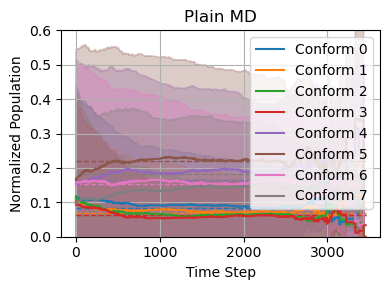

In [23]:
conform_num = 8
dt_in_ns = 0.01

time = np.arange(mean_all_traj.shape[1]) * dt_in_ns
plt.figure(figsize=(4, 3))

for conform in range(conform_num):
    mean = mean_all_traj[conform, :]
    std = std_all_traj[conform, :]
    ref = conform_refer[conform]

    # Plot and capture the line object to get the color
    line, = plt.plot(time, mean, label=f'Conform {conform}')
    plt.fill_between(time, mean - std, mean + std, alpha=0.3, color=line.get_color())

    # Use the same color for the horizontal reference line
    plt.hlines(y=ref, xmin=time[0], xmax=time[-1],
                colors=line.get_color(), linestyles='--', linewidth=1)

plt.ylim(0, 0.6)
plt.xlabel("Time Step")
plt.ylabel("Normalized Population")
plt.title(f"Plain MD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## RMSD over time 

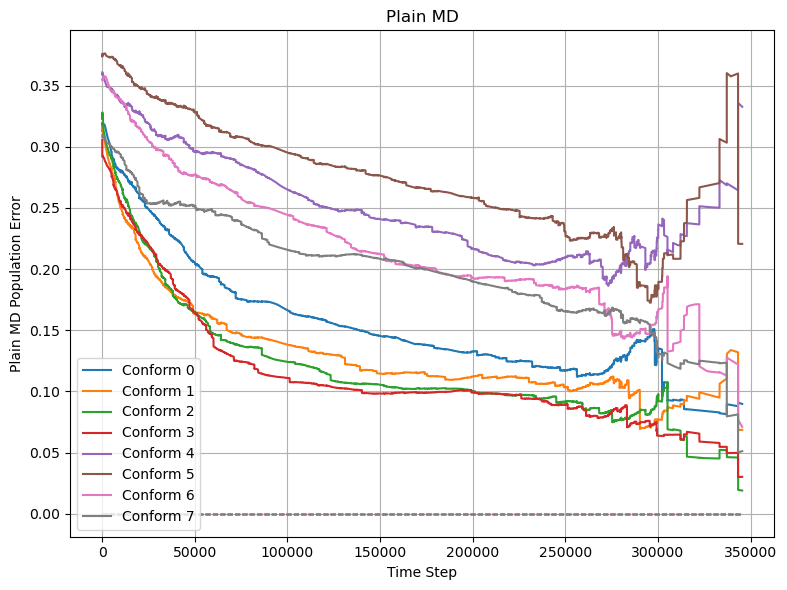

In [24]:
conform_num = 8

time = np.arange(mean_all_traj.shape[1])
plt.figure(figsize=(8, 6))

for conform in range(conform_num):
    rmsd = rmsd_all_traj[conform, :]

    # Plot and capture the line object to get the color
    line, = plt.plot(time, rmsd, label=f'Conform {conform}')
    # Use the same color for the horizontal reference line
    plt.hlines(y=0, xmin=time[0], xmax=time[-1],
                colors=line.get_color(), linestyles='--', linewidth=1)

#plt.ylim(0, 0.3)
plt.xlabel("Time Step")
plt.ylabel("Plain MD Population Error")
plt.title(f"Plain MD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
